In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import torchvision.models as models
from torch.autograd import Variable

## ---------------------- ResNet VAE ---------------------- ##

class ResNet_VAE(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=256):
        super(ResNet_VAE, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim

        # CNN architecture
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)
        # Latent vectors mu and sigma
        self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)      # output = CNN embedding latent variables
        self.fc3_logvar = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)  # output = CNN embedding latent variables

        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4)
        self.relu = nn.ReLU(inplace=True)

        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=(2, 2),
                               padding=(1, 1)),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=(3, 3), stride=(2, 2),
                               padding=(1, 1)),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=(3, 3), stride=(2, 2),
                               padding=(1, 1)),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )


    def encode(self, x):
        x = self.resnet(x)  # ResNet
        x = x.view(x.size(0), -1)  # flatten output of conv

        # FC layers
        x = self.bn1(self.fc1(x))
        x = self.relu(x)
        x = self.bn2(self.fc2(x))
        x = self.relu(x)
        mu, logvar = self.fc3_mu(x), self.fc3_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        x = self.relu(self.fc_bn4(self.fc4(z)))
        x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear')
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z)
        return x_reconst, z, mu, logvar


## ---------------------- Training and Data Loading ---------------------- ##

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the dataset class
class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load data
dataset = SpectrogramDataset(root_dir='C:\\Users\\syudi\\neuralnet\\bubblejet\\bubblejet\\datasetVAEtrain2', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize the model
model = ResNet_VAE()
model.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define the training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        outputs, z, mu, logvar = model(data)
        reconst_loss = F.mse_loss(outputs, data, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = reconst_loss + kl_div
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

print('Training finished!')



#'C:\\Users\\syudi\\neuralnet\\bubblejet\\bubblejet\\datasetVAEtrain2'

C:\Users\syudi\anaconda3\envs\pytorch2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\syudi\anaconda3\envs\pytorch2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 224548.0323
Epoch [2/10], Loss: 218456.5403
Epoch [3/10], Loss: 215593.2184
Epoch [4/10], Loss: 213377.5156
Epoch [5/10], Loss: 211340.2078
Epoch [6/10], Loss: 209399.6054
Epoch [7/10], Loss: 207505.4113
Epoch [8/10], Loss: 205621.4757
Epoch [9/10], Loss: 203742.3557
Epoch [10/10], Loss: 201848.4662
Training finished!


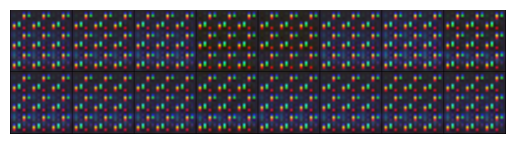

In [2]:
import matplotlib.pyplot as plt

# Define the function to visualize a batch of images
def visualize_images(images, num_images=8):
    images = images.cpu().detach()  # Move to CPU and detach from graph
    grid_img = torchvision.utils.make_grid(images, nrow=num_images, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.axis('off')
    plt.show()

# After training is done, visualize some generated images
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for data in dataloader:
        data = data.to(device)
        outputs, _, _, _ = model(data)
        visualize_images(outputs, num_images=8)  # Display 8 images
        break  # Display only the first batch for simplicity
